<a href="https://colab.research.google.com/github/alexandre-canellas/position_designator/blob/main/notebook/modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexto

Queremos criar um modelo de classificação de jogadores conforme seu desempenho.
O modelo poderá ser utilizado para estimar a posição ideal do jogador e ajudar clubes a montar times com embasamento estatístico.

## Regras de Negócio



1.   Modelo deve considerar performance do jogador conforme feitos por partida (gols, assistências e cartões recebidos)
2.   Modelo deve incluir considerações físicas do jogador (minutos por partida, idade)



## Análise de Dados de Jogadores

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Carregamento de Dados do Transfermrkt

In [2]:
# Dados dos jogadores
url = "https://raw.githubusercontent.com/alexandre-canellas/dados_transfermarkt/refs/heads/main/players.csv"
dataset_players = pd.read_csv(url, delimiter=',')

# Dados de performance
url = "https://raw.githubusercontent.com/alexandre-canellas/dados_transfermarkt/refs/heads/main/appearances.csv"
dataset_performance = pd.read_csv(url, delimiter=',')

# União das tabelas usando chaves de player_id e last_season
dataset = dataset_players.merge(dataset_performance, how='left', on=['player_id','last_season'])

# Selecionando colunas de interesse
dataset = dataset[['player_id','last_season','name','date_of_birth','position','games','minutes_played','goals','assists','yellow_cards','red_cards','market_value_in_eur']]
dataset.head(5)

,player_id,last_season,name,date_of_birth,position,games,minutes_played,goals,assists,yellow_cards,red_cards,market_value_in_eur
0,10,2015,Miroslav Klose,1978-06-09 00:00:00,Attack,36.0,2429.0,12.0,8.0,6.0,0.0,1000000.0
1,26,2017,Roman Weidenfeller,1980-08-06 00:00:00,Goalkeeper,3.0,181.0,0.0,0.0,0.0,0.0,750000.0
2,65,2015,Dimitar Berbatov,1981-01-30 00:00:00,Attack,32.0,1656.0,6.0,0.0,0.0,0.0,1000000.0
3,77,2012,Lúcio,1978-05-08 00:00:00,Defender,4.0,307.0,0.0,0.0,0.0,0.0,200000.0
4,80,2017,Tom Starke,1981-03-18 00:00:00,Goalkeeper,5.0,450.0,0.0,0.0,0.0,0.0,100000.0


### Simplificação das informações

In [3]:
# Informações pessoais não são necessárias -> jogadores referenciados por id
dataset = dataset.drop(columns='name')

# Idade a partir do ano de nascimento
dataset['age'] = dataset['last_season'] - pd.to_datetime(dataset['date_of_birth']).dt.year
dataset = dataset.drop(columns='date_of_birth')

# Minutos por partida
dataset['min_per_match'] = round(dataset['minutes_played'] / dataset['games'],1)

# Podemos unificar cartões conforme a regra 1 vermelho = 2 amarelos
dataset['total_cards'] = dataset['yellow_cards'] + 2 * dataset['red_cards']

dataset = dataset[['player_id','last_season','position','age','goals','assists','total_cards','min_per_match']]
dataset.head(5)

,player_id,last_season,position,age,goals,assists,total_cards,min_per_match
0,10,2015,Attack,37.0,12.0,8.0,6.0,67.5
1,26,2017,Goalkeeper,37.0,0.0,0.0,0.0,60.3
2,65,2015,Attack,34.0,6.0,0.0,0.0,51.8
3,77,2012,Defender,34.0,0.0,0.0,0.0,76.8
4,80,2017,Goalkeeper,36.0,0.0,0.0,0.0,90.0


### Análise dos dados

In [4]:
dataset.isna().sum() / len(dataset)

,0
player_id,0.000000
last_season,0.000000
position,0.000000
age,0.001442
goals,0.319622
assists,0.319622
total_cards,0.319622
min_per_match,0.319622


32% de informação faltante, correspondendo a ~10 mil registros. Tomo a decisão de adicionar informações me baseando na mediana da coluna agrupando por posição.

In [5]:
cols = ['goals','assists','total_cards','min_per_match','age']
positions = dataset.position.unique()

for col in cols:
    for pos in positions:
        mask = dataset.position == pos
        median_value = dataset.loc[mask, col].median()
        dataset.loc[mask, col] = dataset.loc[mask, col].fillna(median_value)

In [6]:
dataset.groupby('position').player_id.count() / len(dataset)

,player_id
position,
Attack,0.273642
Defender,0.318671
Goalkeeper,0.114107
Midfield,0.288059
Missing,0.005521


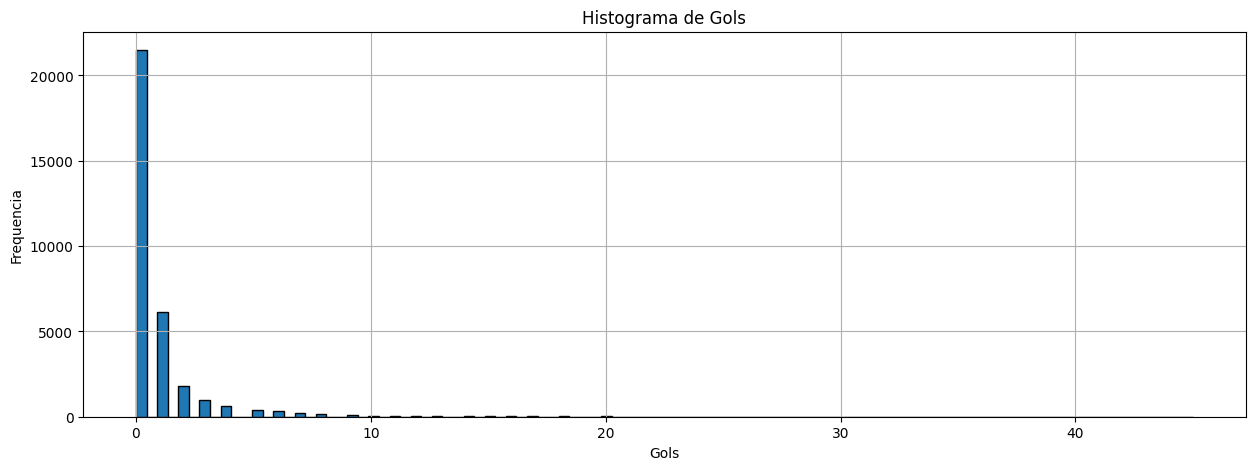

In [7]:
plt.figure(figsize=(15, 5))
plt.hist(dataset['goals'], bins=100, edgecolor='black')
plt.title('Histograma de Gols')
plt.xlabel('Gols')
plt.ylabel('Frequencia')
plt.grid(True)
plt.show()

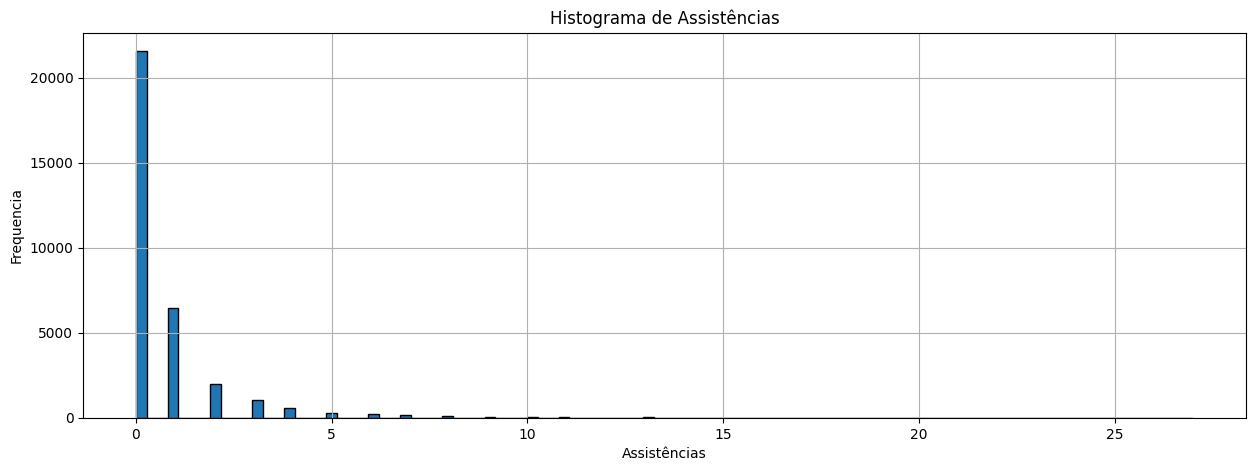

In [8]:
plt.figure(figsize=(15, 5))
plt.hist(dataset['assists'], bins=100, edgecolor='black')
plt.title('Histograma de Assistências')
plt.xlabel('Assistências')
plt.ylabel('Frequencia')
plt.grid(True)
plt.show()

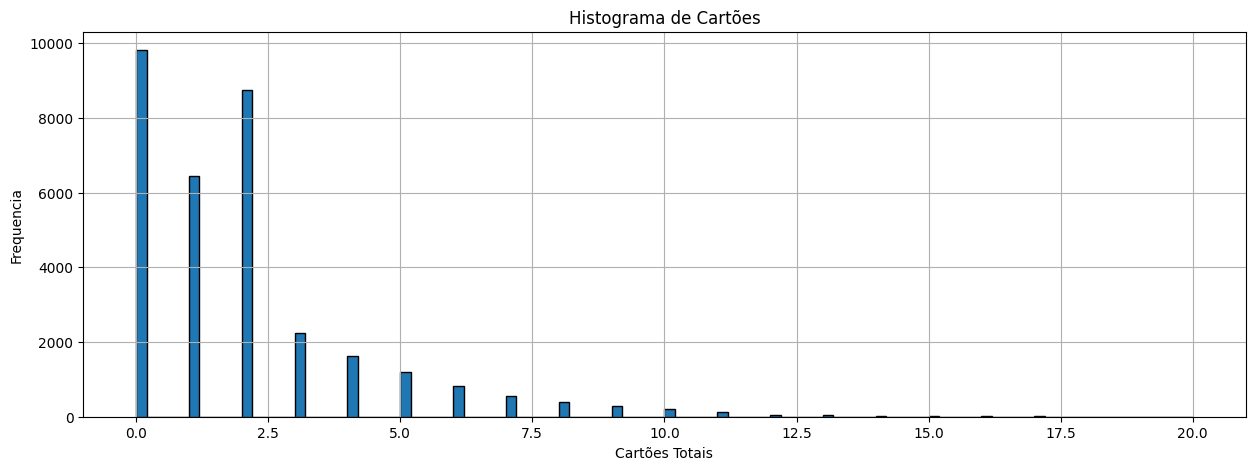

In [9]:
plt.figure(figsize=(15, 5))
plt.hist(dataset['total_cards'], bins=100, edgecolor='black')
plt.title('Histograma de Cartões')
plt.xlabel('Cartões Totais')
plt.ylabel('Frequencia')
plt.grid(True)
plt.show()

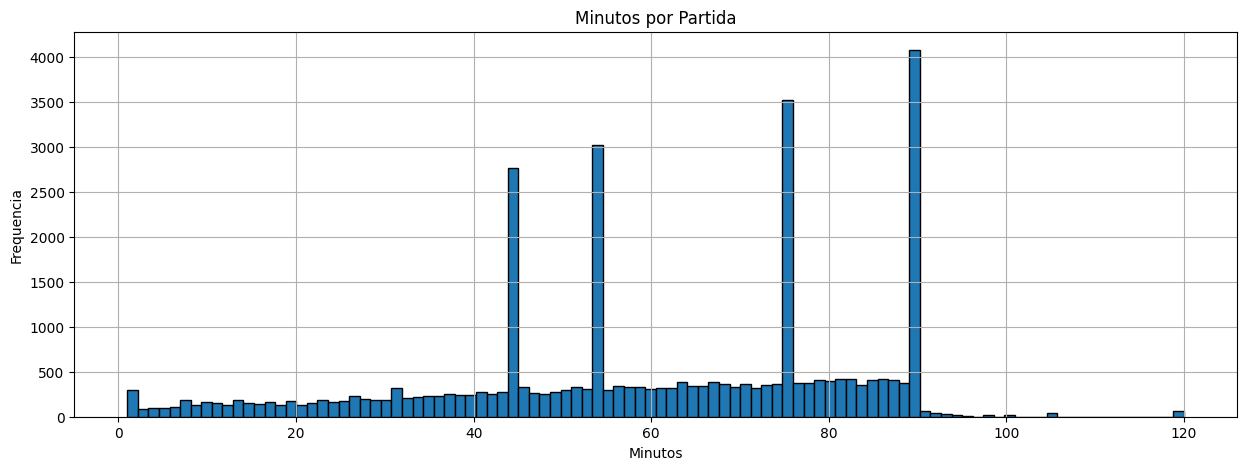

In [10]:
plt.figure(figsize=(15, 5))
plt.hist(dataset['min_per_match'], bins=100, edgecolor='black')
plt.title('Minutos por Partida')
plt.xlabel('Minutos')
plt.ylabel('Frequencia')
plt.grid(True)
plt.show()

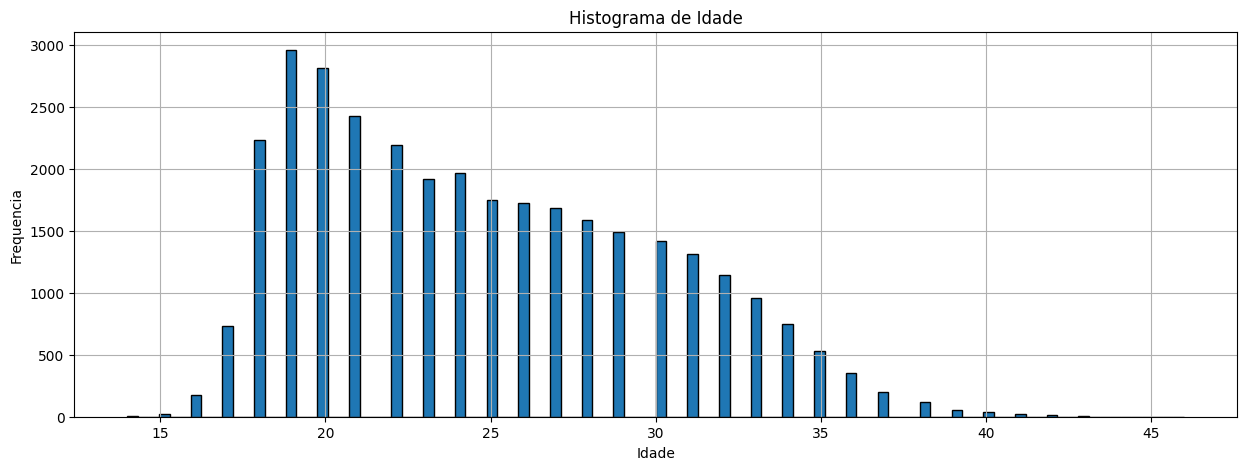

In [11]:
plt.figure(figsize=(15, 5))
plt.hist(dataset['age'], bins=100, edgecolor='black')
plt.title('Histograma de Idade')
plt.xlabel('Idade')
plt.ylabel('Frequencia')
plt.grid(True)
plt.show()

Como esperado, informações de performance e valor tem distribuição desequibilibrada de valores.
Devemos tratar as distribuições para torná-las mais próximas de uma normal.

### Holdout

In [12]:
# Seleção das colunas de interesse
features_cols = ['age','goals','assists','total_cards','min_per_match']
target_col = ['position']

In [13]:
from sklearn.model_selection import train_test_split

# Holdout (80% - 20%)
X_train, X_val, y_train, y_val = train_test_split(
    dataset[features_cols], dataset[target_col], test_size=0.2, stratify=dataset[target_col], random_state=42
)

### Feature Engineering

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Colunas numéricas e categóricas
num_cols = ['age','goals','assists','total_cards','min_per_match']
cat_cols = ['position']

# Pipeline de pré processamento
preprocessor = ColumnTransformer([
    ("num", make_pipeline(StandardScaler()), num_cols)
])

Baseline de Performance dos modelos KNN, Naive Bayes, SVM e Árvore de Decisão

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, accuracy_score

models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Tree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB()
}

results = {}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1 Macro": f1_score(y_val, y_pred, average='macro')
    }

print(results)

{'KNN': {'Accuracy': 0.6683024076061954, 'F1 Macro': 0.665218199618829}, 'SVM': {'Accuracy': 0.6983591473700352, 'F1 Macro': 0.5713711289733359}, 'Tree': {'Accuracy': 0.6425394878086184, 'F1 Macro': 0.6568592258867331}, 'NaiveBayes': {'Accuracy': 0.33185094310688545, 'F1 Macro': 0.2972249699837898}}


### Refinamento de Hiperparâmetros dos 2 melhores modelos (KNN e Árvore)

#### KNN

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

grid = GridSearchCV( make_pipeline(preprocessor, KNeighborsClassifier()), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Validation F1 score:", grid.best_score_)

Best parameters: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}
Validation F1 score: 0.6805701334040613


#### Árvore

In [ ]:
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 15, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 3, 5],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid = GridSearchCV( make_pipeline(preprocessor, DecisionTreeClassifier()), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Validation F1 score:", grid.best_score_)

Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__min_samples_split': 10}
Validation F1 score: 0.7246791894091092


### Avaliação de Performance com Modelos Refinados

In [17]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=9, p=2, weights='distance'),
    "Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, min_samples_split=10)
}

results = {}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1 Macro": f1_score(y_val, y_pred, average='macro')
    }


print(results)

{'KNN': {'Accuracy': 0.6732096304247814, 'F1 Macro': 0.6720383670207302}, 'Tree': {'Accuracy': 0.6989725502223585, 'F1 Macro': 0.7162399744509326}}


### Conclusão

Dentre os modelos observados, podemos observar uma melhor performance entre os modelos de Árvore de Decisão e Nearest Neighbors.
Dentre os quais, a Árvore se tornou melhor em termos de score F-1, em que buscamos um equilíbrio entre recall e precisão.

#### Salvando o modelo para uso

In [18]:
import joblib
from google.colab import files

joblib.dump(pipe, 'tree_model.pkl', compress=3)
files.download('tree_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

files.download("X_val.csv")
files.download("y_val.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>